In [30]:
import os
import glob
from PIL import Image

# フォルダを置く場所を指定
PATH="folder_name"

# 入力画像フォルダ
input_dir = "cup_pre"
#input_dir = "dish_pre"

# リサイズ後のサイズ
resize = 100

# 出力フォルダ名
out_dir = "cup"
#out_dir = "dish"

# フォルダを置く場所に移動
os.chdir(PATH)

# ファイル名
files = glob.glob(input_dir+'/*.jpg')

# 出力フォルダが存在しない場合は作成
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# フォルダを置く場所に移動
os.chdir(PATH)

# 元画像の変換
for file in files:
    img = Image.open(file)
    img_resize = img.resize((resize, resize))
    img_resize.save(os.path.join(PATH,os.path.join(out_dir,os.path.basename(file))))


In [91]:
# 画像水増し
# 既存画像の水平移動、垂直移動、反転、回転を駆使し、各画像を300枚に拡張する。
# 入力画像はcup,dishフォルダから取得する。

import os
import numpy as np
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
import glob
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# フォルダを置く場所を指定
PATH="folder_name"

# フォルダを置く場所に移動
os.chdir(PATH)

# 入力フォルダを指定
#input_dir = "cup"
input_dir = "dish"

# 出力フォルダ
out_dir = input_dir + "_augumented"

# フォルダ内に作りたい合計ファイル数
out_file_count = 300

# 入力フォルダ内のファイル数を返す関数
def count_file(dir):
    file_count = 0
    for file_name in os.listdir(dir):
        # 入力ファイルのパスを取得
        file_path = os.path.join(dir,file_name)            
        # 入力ファイルの有無を確認
        if os.path.isfile(file_path):  
            # ファイル数を数える
            file_count += 1
    return file_count
    print(file_count)
    
# out_file_countに達するまでinput_dir内の画像を拡張する関数
def image_augumentation(input_dir, out_dir, out_file_count):

    # 入力フォルダ内のファイル名を取得
    files = glob.glob(input_dir + '/*.jpg')

    # 入力ファイル数確認
    in_file_count = count_file(input_dir)

    # 出力フォルダが存在しない場合は作成
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    # 入力フォルダの画像を出力フォルダにコピー
    copy_tree(input_dir, out_dir)
            
    for i, file in enumerate(files):

        # RGB画像(PIL形式)の読み込み
        img = load_img(file)
        
        # numpy配列へ変換
        x = img_to_array(img)
        
        # flow関数に合わせてnumpy4次元データに変換(3次元→4次元)
        x = x[np.newaxis]

        # ImageDataGeneratorで画像を増やす        

        # ImageDataGeneratorクラスへの引数をdirectory形式で変数に代入
        params = {
            'width_shift_range': 0.4, 
            'height_shift_range': 0.4,
            'horizontal_flip': True,
            'vertical_flip': True,
            'zoom_range':0.2, 
            'shear_range':0.2,
            'rotation_range': 50,                      
            'fill_mode':"nearest"
        }
        # インスタンス作成
        datagen = ImageDataGenerator(**params)

        # flowメソッドで画像を出力する拡張画像を保存するイテレータを作成・リターン。
        # イテレータに対してnextメソッドを用いることで各画像を出力フォルダに保存する。
        # nextメソッドの実行回数だけ画像が出力される。
        gen = datagen.flow(x, batch_size=1, save_to_dir=out_dir, save_prefix=re.search("[a-zA-Z]+",input_dir).group(), save_format='jpg')
        
        # 繰り返し回数 = (出力したいファイル数 / 現在の入力フォルダ内のファイル数 -1) 繰り返す。
        # 不足分は後で追加する。
        for j in range(out_file_count // in_file_count -1 ):
            batch = gen.next()
        if i+1 == in_file_count:
            # 出力ファイル数確認
            cur_file_count = count_file(out_dir)
            if out_file_count > cur_file_count:
                # 出力枚数が計算より少ない場合があるため多めに考慮。
                for k in range((out_file_count % in_file_count)+10):
                    batch = gen.next()
                    cur_file_count = count_file(out_dir)
                    # 出力フォルダのファイル数が出力したい枚数になったら終了
                    if cur_file_count >= out_file_count:
                        break
                            
image_augumentation(input_dir, out_dir, out_file_count)

C:\Users\akihi\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


データラベル: 0
データラベル: 0
データラベル: 0
データラベル: 1


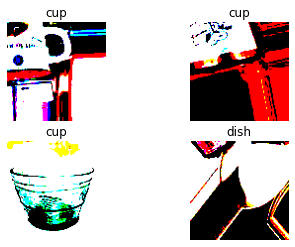

In [92]:
# 各クラスがフォルダ毎に分かれているのを利用して、画像データにラベルを付けxとyのデータセットを作成。

import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input

categories = ["cup_augumented","dish_augumented"]
category_size = len(categories)

# データセット用の配列を用意
def create_data_set():
    data_set = []
    for class_num, category in enumerate(categories):
        path = os.path.join(PATH, category)
        for image_name in os.listdir(path):
            img_pil = load_img(os.path.join(path, image_name))  # 画像読み込み(RGB)
            img_array = img_to_array(img_pil) # NumPy配列変換
            img_preprocessed = preprocess_input(img_array) #既存モデルが学習したフレームワーク(caffe)に合わせて変換。(RGB->BGR,ImageNetの平均値を差引)
            data_set.append([img_preprocessed,  class_num])  # 画像データ、ラベル情報を追加, 0➡cup, 1➡dish

    # データの順番をシャッフルする
    # 乱数生成ジェネレータ作成
    rng = np.random.default_rng()
    # axis=0でシャッフル。
    data_set = rng.permutation(data_set, axis=0)

    # 画像データ
    X = []
    
    # ラベル情報
    y = []
    
    # X,yデータ作成
    for feature, label in data_set:
        X.append(feature)
        y.append(label)
        
    # numpy配列変換
    X = np.array(X)
    y = np.array(y)

    # データ確認
    for i in range(4):
        print("データラベル:",y[i])
        plt.subplot(2, 2, i+1)
        plt.axis('off')
        plt.title(label = 'cup' if y[i] == 0 else 'dish')
        img_array = cv2.cvtColor(X[i],cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)
    plt.show()
    
    return X,y

X_train_val_test, y_train_val_test = create_data_set()

In [93]:
# データをtrain_valとtestにラベルが均等になるよう分割

from sklearn.model_selection import train_test_split

# 学習データ＋検証データとテストデータに分割 (テストデータ:20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_val_test, y_train_val_test, test_size=0.20, stratify = y_train_val_test)

# テストデータをone-hotエンコーディング (train_valデータはKFoldの後で実施)
y_test = to_categorical(y_test,category_size)

print(f"学習・検証データ{X_train_val.shape},学習・検証ラベル{y_train_val.shape}")
print(f"テストデータ{X_test.shape},テストラベル{y_test.shape}")   

学習・検証データ(480, 100, 100, 3),学習・検証ラベル(480,)
テストデータ(120, 100, 100, 3),テストラベル(120, 2)


In [141]:
# モデルの構築とコンパイル

from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

# コールバック(early stopping、重みの保存)
ch_pt = callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,save_weights_only=True)
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
rd_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

def fine_tuning_model():
    # モデルを作成する(VGG16を元に今回の画像分類に合わせて変更)
    base_model_avg = tf.keras.applications.vgg16.VGG16(include_top=False, pooling="avg", input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))

    x = base_model_avg.output
    x = Dense(256)(x)
    x = BatchNormalization(axis = 1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128)(x)
    x = BatchNormalization(axis = 1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    # one-hotエンコーディング-> 2, ２値分類のため、0~1を出力するsigmoid関数が最適と思われる。
    x = Dense(category_size, activation="sigmoid")(x)

    # モデルを用意
    model_functional = Model(inputs = base_model_avg.input, outputs = x)
    
    # モデルの重みを15層目まで凍結
    for layer in model_functional.layers[:16]:
        layer.trainable = False
    
    # モデルのコンパイル
    model_functional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 再度モデル構造を確認
    print(model_functional.summary())
    
    return model_functional


In [142]:
# モデル構築～コンパイル～学習
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.initializers import TruncatedNormal

n_splits = 5
epochs = 50
result_t = []
test_f1 = []

y_train_val_pred = np.zeros(len(y_train_val))
cv = StratifiedKFold(n_splits=n_splits,random_state=42,shuffle=True)

for i,(trn_index, val_index) in enumerate(cv.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val[trn_index], X_train_val[val_index]
    y_train, y_val = y_train_val[trn_index], y_train_val[val_index]

    # 学習用にOne-Hotエンコーディング
    y_train = to_categorical(y_train, category_size)
    y_val = to_categorical(y_val, category_size)

    # モデルを読み込み
    model_functional = fine_tuning_model()
    
    # 作成されたモデルについて、val_lossが最も低いepochのデータを保存
    result = model_functional.fit(x=X_train, y=y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val),callbacks=[ch_pt,rd_lr,es_cb])
    result_t.append(result)
    
    # y_train_val_predにブロックごとに評価データの予測結果を埋めていく。
    # この時、argmaxにより、One-Hotエンコーディング形式からラベル形式に変換される。
    # [0.9 0.1] ➡ 0.
    y_train_val_pred[val_index] = np.argmax(model_functional.predict(X_val),axis=1)

    # 作成したモデルでテストファイルを予測する。
    y_pred = model_functional.predict(X_test)
    
    # 予測値を丸める
    y_pred = np.round(y_pred)
    
    # F値を計算
    f1 = f1_score(y_test, y_pred, average="micro")

    # test_f1配列に結果を追加(KFoldのブロック数だけ追加される。今回は5個)
    test_f1.append(f1)
    
    # モデル全体の保存
    model_functional.save(f'vgg16_ft_trained\\my_model-{i}')

# oofデータの予測結果の正解率を計算。この時y_train_valはOne-Hotエンコーディングを行う前の
# ラベル形式であり、y_train_val_predもラベル形式なので、正しく正解率を計算できる。
score = accuracy_score(y_train_val, y_train_val_pred)


Model: "functional_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)     

KeyboardInterrupt: 

In [96]:
# oofデータの予測スコア
print("oofデータ正解率:{}".format(score))
print("各ブロックF値:{}".format(test_f1))

oofデータ正解率:0.9979166666666667
各ブロックF値:[0.9833333333333333, 0.9833333333333333, 0.975, 0.9916666666666667, 0.9833333333333333]


In [37]:
# テストデータの予測、評価
import numpy as np
from sklearn.metrics import f1_score

# 作成したモデルでテストファイルを予測する。
y_pred = model_functional.predict(X_test)

# 予測値を丸める
y_pred = np.round(y_pred)
#print(y_pred)

# F1値を計算
# averageオプションの参考: https://qiita.com/isobe_mochi/items/beb4357d69f6886ac05d
f1 = f1_score(y_test, y_pred, average="micro")
print(f"f値:{f1}")
f1_2 = f1_score(y_test, y_pred, average="macro")
print(f"f値_マクロ:{f1_2}")


f1値:0.9916666666666667
f1値_マクロ:0.9916660879227723


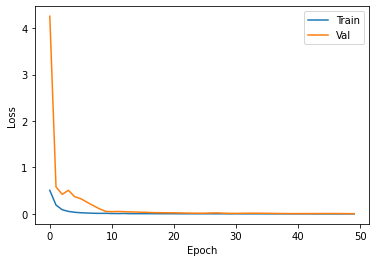

In [107]:
# 損失グラフ
from matplotlib import pyplot as plt

# 最後に学習したモデルの損失グラフ
KFold_number = 2

# 折れ線グラフによる学習データの損失の描画
plt.plot(result_t[KFold_number].history['loss'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result_t[KFold_number].history['val_loss'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 描画の実行
plt.show()

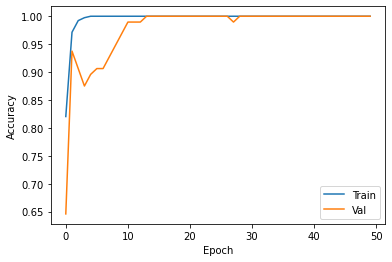

In [108]:
# 正解率グラフ

# 折れ線グラフによる学習データの正解率の描画
plt.plot(result_t[KFold_number].history['accuracy'])

# 折れ線グラフによる検証データの正解率の描画
plt.plot(result_t[KFold_number].history['val_accuracy'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# 描画の実行
plt.show()

In [126]:
# 敢えてBatchNormalizationとDropoutを外して低い精度を出すテスト
# モデルの構築とコンパイル

from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

# コールバック(early stopping、重みの保存)
ch_pt = callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,save_weights_only=True)
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
rd_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

def fine_tuning_model_l():
    # モデルを作成する(VGG16を元に今回の画像分類に合わせて変更)
    base_model_avg = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))

    x = base_model_avg.output
    x = Flatten()(x)
    x = Dense(256)(x)
#    x = BatchNormalization(axis = 1)(x)
    x = Activation('relu')(x)
#    x = Dropout(0.4)(x)
    x = Dense(128)(x)
#    x = BatchNormalization(axis = 1)(x)
    x = Activation('relu')(x)
#    x = Dropout(0.4)(x)
    
    # one-hotエンコーディング-> 2, ２値分類のため、0~1を出力するsigmoid関数が最適と思われる。
    x = Dense(category_size, activation="sigmoid")(x)

    # モデルを用意
    model_functional_l = Model(inputs = base_model_avg.input, outputs = x)
    
    # モデルの重みを15層目まで凍結
    for layer in model_functional_l.layers[:16]:
        layer.trainable = False
    
    # モデルのコンパイル
    model_functional_l.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 再度モデル構造を確認
    print(model_functional_l.summary())
    
    return model_functional_l


In [127]:
# 敢えて精度を下げるテスト
# モデル構築～コンパイル～学習
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.initializers import TruncatedNormal

n_splits = 5
epochs = 50
result_t = []
test_f1 = []

y_train_val_pred = np.zeros(len(y_train_val))
cv = StratifiedKFold(n_splits=n_splits,random_state=42,shuffle=True)

for i,(trn_index, val_index) in enumerate(cv.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val[trn_index], X_train_val[val_index]
    y_train, y_val = y_train_val[trn_index], y_train_val[val_index]

    # 学習用にOne-Hotエンコーディング
    y_train = to_categorical(y_train, category_size)
    y_val = to_categorical(y_val, category_size)

    # モデルを読み込み
    model_functional_l = fine_tuning_model_l()
    
    # 作成されたモデルについて、val_lossが最も低いepochのデータを保存
    result = model_functional_l.fit(x=X_train, y=y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val),callbacks=[ch_pt,rd_lr,es_cb])
    result_t.append(result)
    
    # y_train_val_predにブロックごとに評価データの予測結果を埋めていく。
    # この時、argmaxにより、One-Hotエンコーディング形式からラベル形式に変換される。
    # [0.9 0.1] ➡ 0.
    y_train_val_pred[val_index] = np.argmax(model_functional_l.predict(X_val),axis=1)
    
    # 作成したモデルでテストファイルを予測する。
    y_pred = model_functional_l.predict(X_test)
    
    # 予測値を丸める
    y_pred = np.round(y_pred)
    
    # F1値を計算
    f1 = f1_score(y_test, y_pred, average="micro")
    print(f"f値:{f1}")
    test_f1.append(f1)

    # モデル全体の保存
    model_functional_l.save(f'vgg16_ft_trained\\my_model-{i}')

# oofデータの予測結果の正解率を計算。この時y_train_valはOne-Hotエンコーディングを行う前の
# ラベル形式であり、y_train_val_predもラベル形式なので、正しく正解率を計算できる。
score = accuracy_score(y_train_val, y_train_val_pred)


Model: "functional_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)     

Epoch 33/50
6/6 [==============================] - 25s 4s/step - loss: 4.4649e-06 - accuracy: 1.0000 - val_loss: 0.0941 - val_accuracy: 0.9688
Epoch 34/50
6/6 [==============================] - 27s 5s/step - loss: 4.3125e-06 - accuracy: 1.0000 - val_loss: 0.0945 - val_accuracy: 0.9688
Epoch 35/50
6/6 [==============================] - 31s 5s/step - loss: 4.1930e-06 - accuracy: 1.0000 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 00035: early stopping
f値:0.975
INFO:tensorflow:Assets written to: vgg16_ft_trained\my_model-0\assets
Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100,

6/6 [==============================] - 20s 3s/step - loss: 0.0117 - accuracy: 0.9948 - val_loss: 0.0287 - val_accuracy: 0.9896
Epoch 11/50
6/6 [==============================] - 20s 3s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2125 - val_accuracy: 0.9479
Epoch 12/50
6/6 [==============================] - 23s 4s/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.1711 - val_accuracy: 0.9583
Epoch 13/50
6/6 [==============================] - 24s 4s/step - loss: 0.0284 - accuracy: 0.9974 - val_loss: 0.3046 - val_accuracy: 0.9375
Epoch 14/50
6/6 [==============================] - 24s 4s/step - loss: 0.0708 - accuracy: 0.9896 - val_loss: 0.3166 - val_accuracy: 0.8750
Epoch 15/50
6/6 [==============================] - 24s 4s/step - loss: 0.0379 - accuracy: 0.9896 - val_loss: 0.0154 - val_accuracy: 0.9896
Epoch 16/50
6/6 [==============================] - 24s 4s/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9792
Epoch 17/50
6/6 [======================

6/6 [==============================] - 25s 4s/step - loss: 0.0919 - accuracy: 0.9688 - val_loss: 0.3695 - val_accuracy: 0.9375
Epoch 9/50
6/6 [==============================] - 26s 4s/step - loss: 0.1045 - accuracy: 0.9583 - val_loss: 0.1282 - val_accuracy: 0.9167
Epoch 10/50
6/6 [==============================] - 24s 4s/step - loss: 0.0358 - accuracy: 0.9948 - val_loss: 0.1599 - val_accuracy: 0.9479
Epoch 11/50
6/6 [==============================] - 30s 5s/step - loss: 0.0099 - accuracy: 0.9948 - val_loss: 0.0831 - val_accuracy: 0.9792
Epoch 12/50
6/6 [==============================] - 32s 5s/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.1248 - val_accuracy: 0.9688
Epoch 13/50
6/6 [==============================] - 27s 4s/step - loss: 0.0065 - accuracy: 0.9974 - val_loss: 0.2576 - val_accuracy: 0.9583
Epoch 14/50
6/6 [==============================] - 27s 4s/step - loss: 4.2216e-04 - accuracy: 1.0000 - val_loss: 0.1472 - val_accuracy: 0.9583
Epoch 15/50
6/6 [===================

In [128]:
print(test_f1)
print(score)

[0.975, 0.9539748953974896, 0.975, 0.9666666666666667, 0.946058091286307]
0.9729166666666667


In [58]:
# 敢えて精度を下げるテスト
# テストデータの予測、評価
import numpy as np
from sklearn.metrics import f1_score

# 作成したモデルでテストファイルを予測する。
y_pred = model_functional.predict(X_test)

# 予測値を丸める
y_pred = np.round(y_pred)
#print(y_pred)

# F1値を計算
# averageオプションの参考: https://qiita.com/isobe_mochi/items/beb4357d69f6886ac05d
f1 = f1_score(y_test, y_pred, average="micro")
print(f"f値:{f1}")


f値:0.9917355371900827


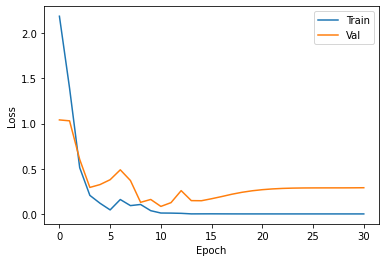

In [139]:
# 敢えて制度を下げるテスト
# 損失グラフ
from matplotlib import pyplot as plt

# 最後に学習したモデルの損失グラフ
KFold_number = 4

# 折れ線グラフによる学習データの損失の描画
plt.plot(result_t[KFold_number].history['loss'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result_t[KFold_number].history['val_loss'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 描画の実行
plt.show()

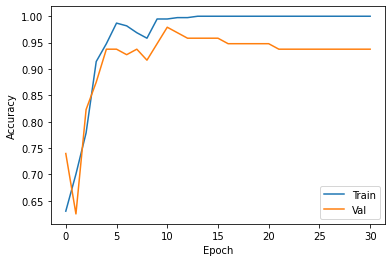

In [140]:
# 敢えて精度を下げるテスト
# 正解率グラフ

# 折れ線グラフによる学習データの正解率の描画
plt.plot(result_t[KFold_number].history['accuracy'])

# 折れ線グラフによる検証データの正解率の描画
plt.plot(result_t[KFold_number].history['val_accuracy'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# 描画の実行
plt.show()

In [143]:
print(score)
print(f1)

0.9729166666666667
0.946058091286307
